# Construct NERC regions

Using the point data generated in the previous notebook, I hand-traced the boundaries I though best, creating ["cutout" shapes in the previous SPP region](https://github.com/cmutel/nerc-regions/blob/master/data/cutouts_spp.gpkg). We can then use these cutouts, combined with previous cutouts used to generate the ecoinvent map, and the state boundaries from Natural Earth, to define each NERC region (aside from Alaska and Hawai'i, where we use the whole state).

In [1]:
import fiona
from shapely.geometry import shape, MultiPolygon, mapping, Polygon
from fiona.crs import from_epsg
from shapely.ops import unary_union
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
def to_valid_multipolygon(geom):
    if not geom.is_valid:
        geom = geom.buffer(0.0)
    if not isinstance(geom, MultiPolygon):
        geom = MultiPolygon([geom])
    assert geom.is_valid
    return geom    

In [3]:
usa = {}

for i, layername in enumerate(fiona.listlayers('zip://data/natural-earth/ne_10m_admin_1_states_provinces.zip')):
    with fiona.open('zip://data/natural-earth/ne_10m_admin_1_states_provinces.zip', layer=i) as src:
        usa = {
            feature['properties']['name']: to_valid_multipolygon(shape(feature['geometry']))
            for feature in src
            if feature['properties']['admin'] == 'United States of America'
        }

In [4]:
cutouts = {}

with fiona.open('data/cutouts_spp.gpkg', layer=0) as src:
    cutouts = {
        feature['properties']['name']: to_valid_multipolygon(shape(feature['geometry']))
        for feature in src
    }

In [5]:
cutouts

{'mro_nm': <MULTIPOLYGON (((-103.051 32.49, -103.393 32.523, -103.735 32.225, -104.099 ...>,
 'mro_texas1': <MULTIPOLYGON (((-103.153 32.484, -102.646 32.657, -102.231 33.113, -101.734...>,
 'wecc_texas': <MULTIPOLYGON (((-105.031 30.567, -104.712 31.389, -104.156 31.645, -103.572...>,
 'mro_texas_east': <MULTIPOLYGON (((-95.406 33.954, -95.269 33.86, -95.168 33.823, -95.168 33.7...>,
 'tre_ok': <MULTIPOLYGON (((-100.039 34.874, -99.962 34.902, -99.938 34.858, -99.942 34...>}

In [6]:
with fiona.open('data/cutouts/mro.gpkg', layer=0) as src:
    mro_cutout = to_valid_multipolygon(shape(next(iter(src))['geometry']))
    
with fiona.open('data/cutouts/mro_ill.gpkg', layer=0) as src:
    mro_ill_cutout = to_valid_multipolygon(shape(next(iter(src))['geometry']))    

In [7]:
with fiona.open('data/cutouts/serc.gpkg', layer=0) as src:
    serc_cutout = to_valid_multipolygon(shape(next(iter(src))['geometry']))

In [8]:
def plot(geom):
    gpd.GeoSeries(geom).plot()
    plt.show()
    return plt

# WECC

In [9]:
wecc = unary_union(
    [cutouts['wecc_texas'].intersection(usa['Texas']), usa['New Mexico'].difference(cutouts['mro_nm'])] + 
    [usa[key].difference(mro_cutout) for key in ('Montana', 'South Dakota', 'Nebraska')] + 
    [usa[key] for key in 
        ('Washington', 'Oregon', 'California', 'Idaho', 'Wyoming', 'Utah', 'Arizona', 'Nevada', 'Colorado')
     ]
)

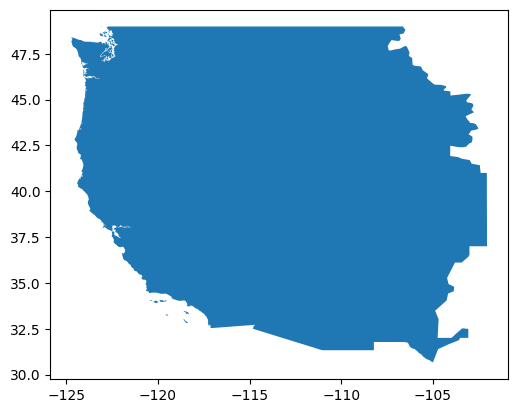

In [10]:
gpd.GeoSeries(wecc).plot()
plt.show()

# MRO

In [11]:
mro = unary_union(
    [    
        cutouts['mro_nm'].intersection(usa['New Mexico']), 
        cutouts['mro_texas1'].intersection(usa['Texas']),
        cutouts['mro_texas_east'].intersection(usa['Texas']).difference(serc_cutout),
        usa['Oklahoma'].difference(cutouts['tre_ok']),
        mro_ill_cutout.intersection(usa['Illinois'])
    ] +    
    [usa[key].difference(serc_cutout) for key in ('Missouri', 'Arkansas', 'Louisiana')] + 
    [usa[key].intersection(mro_cutout) for key in ('Montana', 'South Dakota', 'Nebraska', 'Wisconsin')] + 
    [usa[key] for key in 
        ('North Dakota', 'Kansas', 'Iowa', 'Minnesota')
     ]
)

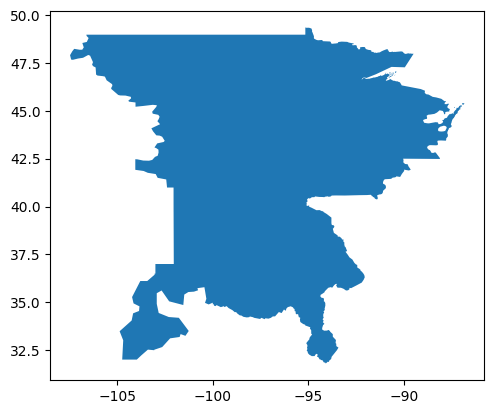

<module 'matplotlib.pyplot' from '/Users/chrismutel/virtualenvs/gis/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [12]:
plot(mro)

# SERC

In [13]:
serc = unary_union(
    [
        usa[key].intersection(serc_cutout)
        for key in 
        ('Missouri', 'Arkansas', 'Louisiana', 'Texas', 'Illinois', 'Virginia', 'Kentucky')] + 
    [usa[key] for key in 
        ('Tennessee', 'Alabama', 'Mississippi', 'Georgia', 'South Carolina', 'North Carolina', 'Florida')
     ]
)

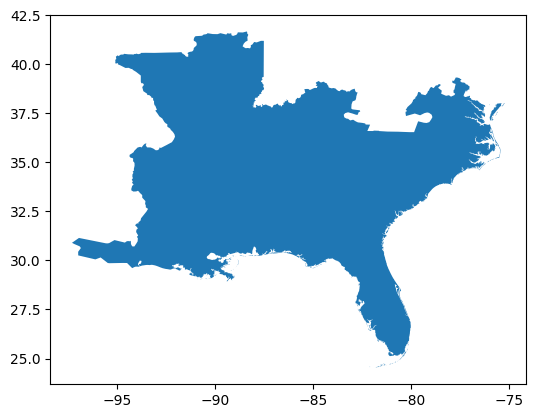

<module 'matplotlib.pyplot' from '/Users/chrismutel/virtualenvs/gis/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [14]:
plot(serc)

# TRE

In [15]:
tre = unary_union(
    [
        usa['Texas'].difference(serc_cutout).difference(cutouts['wecc_texas']).difference(
            cutouts['mro_texas1']).difference(cutouts['mro_texas_east']),
        usa['Oklahoma'].intersection(cutouts['tre_ok']),
    ]
)

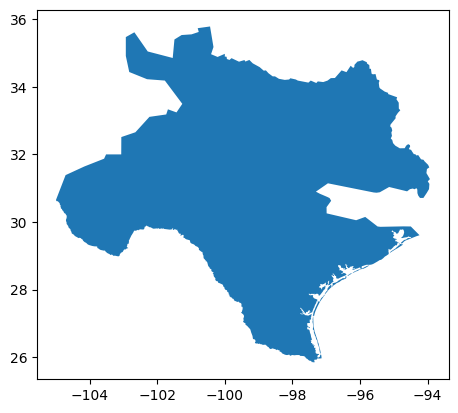

<module 'matplotlib.pyplot' from '/Users/chrismutel/virtualenvs/gis/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [16]:
plot(tre)

# NPCC

In [17]:
npcc = unary_union(
    [usa[key] for key in 
        ('New York', 'Connecticut', 'Rhode Island', 'Massachusetts', 'Vermont', 'New Hampshire', 'Maine')
     ]
)

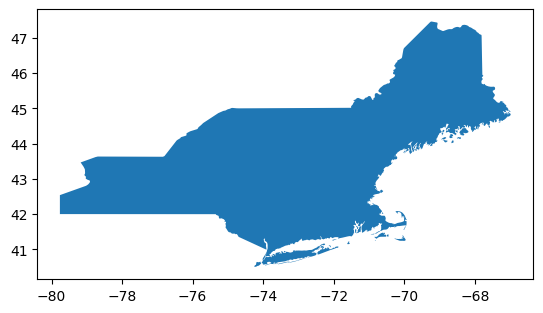

<module 'matplotlib.pyplot' from '/Users/chrismutel/virtualenvs/gis/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [18]:
plot(npcc)

# RFC

In [19]:
rfc = unary_union(
    [
        usa['Illinois'].difference(mro_ill_cutout).difference(serc_cutout),
        usa['Wisconsin'].difference(mro_cutout),
    ] + 
    [
        usa[key].difference(serc_cutout)
        for key in 
        ('Virginia', 'Kentucky')] + 
    [usa[key] for key in 
        ('Indiana', 'Ohio', 'West Virginia', 'District of Columbia', 'Maryland', 'Delaware', 'Pennsylvania', 'New Jersey', 'Michigan')
     ]
)

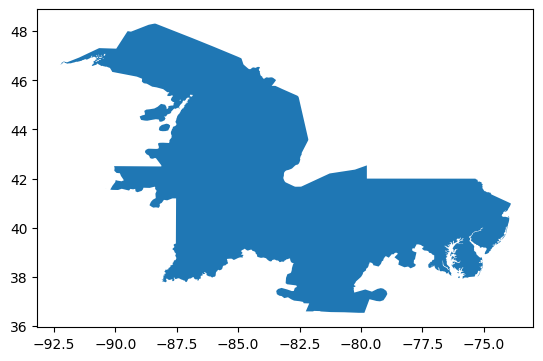

<module 'matplotlib.pyplot' from '/Users/chrismutel/virtualenvs/gis/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [20]:
plot(rfc)

# Fix intersecting geometries

In [21]:
npcc = to_valid_multipolygon(npcc.difference(rfc))

In [22]:
for other in (mro, rfc, tre):
    serc = serc.difference(other)
    
serc = to_valid_multipolygon(serc)

# Fix interior holes with zero area

The GIS operations can create small interior holes with almost zero area, due to floating point errors. This can be easily removed with the following:

In [27]:
def fix_multipolygon(geom):
    mp = to_valid_multipolygon(geom)
    return MultiPolygon([remove_small_holes(obj) for obj in geom.geoms])

In [24]:
def remove_small_holes(polygon, max_area = 1e-4):
    for ring in polygon.interiors:
        ring_geom = Polygon(ring)
        if(ring_geom.area < max_area):
            polygon = polygon.union(ring_geom.buffer(1e-5))
    return polygon

Note, however, that this above functions don't fix evverything. I manually fixed multiple errors where there were zero-area intrusions into polygons.

# Write geometries to new Geopackage

In [28]:
schema =  {
    'geometry': 'MultiPolygon',
    'properties': {'name': 'str'},
}

data = [
    (mro, 'mro'),
    (serc, 'serc'),
    (npcc, 'npcc'),
    (wecc, 'wecc'),
    (rfc, 'rfc'),
    (tre, 'tre')
]

with fiona.open(
        'data/output/nerc_regions.gpkg', 
        'w',
        crs=from_epsg(4326),
        driver='GPKG', 
        schema=schema
    ) as output:
    for x, y in data:
        output.write({'geometry': mapping(fix_multipolygon(to_valid_multipolygon(x))), 'properties': {'name': y}})

## Converting to other GIS formats

```bash
ogr2ogr -f GeoJson data/output/nerc_regions.geojson data/output/nerc_regions.gpkg
ogr2ogr -f KML data/output/nerc_regions.kml data/output/nerc_regions.gpkg
```